Code adapted from:
Juho Laitala, Mingzhe Jiang, Elise Syrjälä, Emad Kasaeyan Naeini, Antti
Airola, Amir M. Rahmani, Nikil D. Dutt, and Pasi Liljeberg. 2020. Robust
ECG R-peak Detection Using LSTM. In The 35th ACM/SIGAPP Symposium
on Applied Computing (SAC ’20), March 30-April 3, 2020, Brno, Czech Republic
ACM, New York, NY, USA, Article 4, 8 pages. https://doi.org/10.1145/3341105.
3373945

In [38]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Importing needed libraries
from matplotlib import pyplot as plt
from ecg2rr import data
import wfdb
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly


# Now you can import
from ecg2rr import data
import tensorflow
from tensorflow.keras import layers, models, Input
import numpy as np

In [39]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [40]:
# # path = 'saved_data/math_functions_single.nc'
# import xarray as xr

# path = '/nsls2/users/shasko/Repos/ecg2rr/ecg2rr/ds_combined_500_patterns_NaCl.nc'
# ds = xr.open_dataset(path, engine="netcdf4")
# gaussians = ds["Intensities"]
# binary = ds["binary_arr"]
# x = ds["tth"].values


In [41]:
path = '/nsls2/users/shasko/Repos/ecg2rr/ecg2rr/math_functions_smalldataset.nc'
ds = xr.open_dataset(path, engine="netcdf4")

gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
print(type(binary))


# for j in range(binary.shape[0]):
#     idx = np.where(binary[j] == 1)[0][0] # because there's only 1 "1" we can use [0][0]
#     binary[j][idx - 2] = 1
#     binary[j][idx - 1] = 1
#     binary[j][idx + 1] = 1
#     binary[j][idx + 2] = 1

x = ds["x"].values

<class 'numpy.ndarray'>


In [42]:
ds

<xarray.Dataset>
Dimensions:    (pattern: 5000, x: 1000)
Coordinates:
  * pattern    (pattern) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
  * x          (x) float64 0.0 0.01001 0.02002 0.03003 ... 9.97 9.98 9.99 10.0
Data variables:
    Gaussians  (pattern, x) float64 2.174e-17 3.766e-17 ... 2.613e-48 9.194e-49
    BinaryArr  (pattern, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [43]:
import sklearn
from sklearn.model_selection import train_test_split

train_gaussians, test_gaussians, train_binary, test_binary = train_test_split(gaussians, binary, test_size=0.2, shuffle=False)

In [44]:
gauss_signals_train = [signal for signal in train_gaussians]
gauss_signals_test = [signal for signal in test_gaussians]

binary_labels_train = [label for label in train_binary]
binary_labels_test = [label for label in test_binary]

In [45]:
# import sklearn
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# gauss_signals_train_sc = scaler.fit_transform(gauss_signals_train)
# gauss_signals_test_sc = scaler.transform(gauss_signals_test)

In [46]:
import wfdb
from wfdb.processing import (
    resample_singlechan,
    find_local_peaks,
    correct_peaks,
    normalize_bound
)

In [47]:
def data_generator(signals, labels, win_size, batch_size):
   
    while True:
        X, y = [], []

        while len(X) < batch_size:
            i = np.random.randint(0, len(signals))
            sig = signals[i]
            lbl = labels[i]

            if len(sig) <= win_size + 4:
                continue  # skip short signals

            start = np.random.randint(2, len(sig) - win_size - 2)
            end = start + win_size

            data_win = sig[start:end]
            label_win = lbl[start:end]

            # Pad 1s ±2 samples around every 1 in label_win
            padded_label = label_win.copy()
            ones = np.where(label_win == 1)[0]
            for p in ones:
                for offset in [-2, -1, 1, 2]:
                    if 0 <= p + offset < win_size:
                        padded_label[p + offset] = 1

            # Normalize signal window to (0, 1)
            # data_win = normalize_bound(data_win, lb=0, ub=1)

            # Normalized locally
            data_win = (data_win - np.min(data_win))/(np.max(data_win) - np.min(data_win))

            # Normalized globally
            # low = np.min(signals)
            # high = np.max(signals)
            # data_win = (data_win - low)/(high - low)

            X.append(data_win)
            y.append(padded_label)

        X = np.array(X).reshape(batch_size, win_size, 1)
        y = np.array(y).reshape(batch_size, win_size, 1).astype(int)

        yield X, y

In [48]:
gen = data_generator(gauss_signals_train, binary_labels_train, win_size=990, batch_size=64)
X_batch, y_batch = next(gen)

In [49]:
n = next(gen)

<class 'tuple'>
2
(64, 990, 1)
(64, 990, 1)


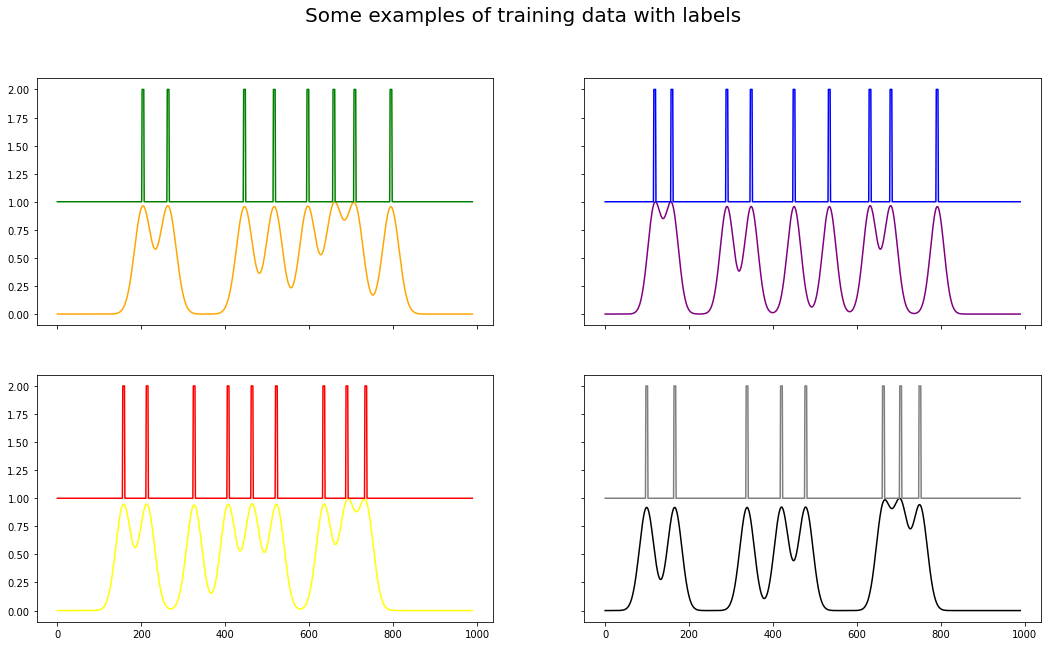

In [50]:

print(type(n))         # likely a tuple
print(len(n))          # 2: probably (inputs, labels)
print(n[0].shape)      # input batch shape
print(n[1].shape)      # label batch shape

# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10), fig.set_figwidth(18)
fig.suptitle('Some examples of training data with labels', size=20)

# first index refers to whether it's an input or label, so noisy signal is input and peaks are labels
axs[0, 0].plot(n[0][0], color='orange')
axs[0, 0].plot(n[1][0]+1, color='green')

axs[0, 1].plot(n[0][1], color='purple')
axs[0, 1].plot(n[1][1]+1, color='blue')

axs[1, 0].plot(n[0][2], color='yellow')
axs[1, 0].plot(n[1][2]+1, color='red')

axs[1, 1].plot(n[0][3], color='black')
axs[1, 1].plot(n[1][3]+1, color='grey')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [51]:
n_batch, n_timesteps, n_input_dim = 64, 990, 1

model = models.Sequential()
model.add(Input(shape=(n_timesteps, n_input_dim)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [52]:
training_gen = data_generator(gauss_signals_train, binary_labels_train, win_size=n_timesteps, batch_size=n_batch)

In [53]:
model.fit(training_gen,
          steps_per_epoch=40,
          epochs=8)

Epoch 1/8
40/40 [==============================] - 59s 1s/step - loss: 0.3326 - acc: 0.9632
Epoch 2/8
40/40 [==============================] - 46s 1s/step - loss: 0.1324 - acc: 0.9646
Epoch 3/8
40/40 [==============================] - 44s 1s/step - loss: 0.0729 - acc: 0.9677
Epoch 4/8
40/40 [==============================] - 43s 1s/step - loss: 0.0379 - acc: 0.9877
Epoch 5/8
40/40 [==============================] - 43s 1s/step - loss: 0.0242 - acc: 0.9927
Epoch 6/8
40/40 [==============================] - 43s 1s/step - loss: 0.0197 - acc: 0.9939
Epoch 7/8
40/40 [==============================] - 42s 1s/step - loss: 0.0165 - acc: 0.9950
Epoch 8/8
40/40 [==============================] - 43s 1s/step - loss: 0.0142 - acc: 0.9959


In [54]:
testing_gen = data_generator(gauss_signals_test, binary_labels_test, win_size=n_timesteps, batch_size=n_batch)

In [55]:
gauss_test, label_test = next(testing_gen)

In [56]:
label_test.shape

(64, 990, 1)

In [57]:
binary_pred = model.predict(gauss_test)

In [58]:
binary_pred.shape

(64, 990, 1)

In [59]:
np.where(binary_pred[5] > 1e-2)[0]
#binary_pred[5]
binary_pred[5][750:760]

array([[6.8706274e-04],
       [4.9307942e-04],
       [3.7062168e-04],
       [2.8631091e-04],
       [2.2515655e-04],
       [1.7961860e-04],
       [1.4510751e-04],
       [1.1944771e-04],
       [9.9986792e-05],
       [8.5085630e-05]], dtype=float32)

In [60]:
plt.close('all')

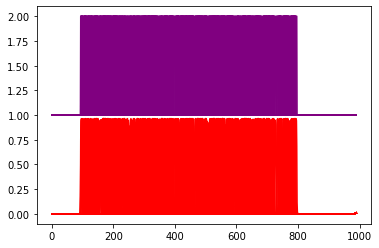

In [61]:
plt.figure()
for j in range(64):
    plt.plot(binary_pred[j], color='red')
    plt.plot(label_test[j] + 1, color='purple')
plt.show()

In [62]:
binary_pred.shape

(64, 990, 1)

In [63]:
# evaluate accuracy
# use f1 score, set prob >= 60% as positive, else negative

binary_pred_adjusted = np.zeros_like(binary_pred)

for j in range(binary_pred.shape[0]):
    idx = np.where(binary_pred[j] >= 0.6)[0]
    binary_pred_adjusted[j][idx] = 1


In [64]:
plt.close('all')

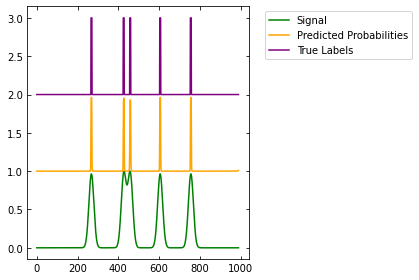

In [66]:
plt.figure()

for j in range(1):
    plt.plot(gauss_test[j], color='green', label='Signal')
    plt.plot(binary_pred[j] + 1, color='orange', label='Predicted Probabilities')
    plt.plot(label_test[j] + 2, color='purple', label='True Labels')

plt.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('test_RNN_NaCl_localscaling.png')
plt.show()